In [131]:
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [132]:
root_path = '.\\dumpsite_data\\VOC2012'
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
file_Annotations = os.path.join(train_path, "Annotations")

In [133]:
object_class = []
for each_xml in os.listdir(file_Annotations):
    pic_xml = os.path.join(file_Annotations, each_xml)
    tree = ET.parse(pic_xml)
    root = tree.getroot()
    for object_elem in root.findall('object'):
        name_elem_value = object_elem.find('name').text
        object_class.append(name_elem_value)
classes = set(object_class)
print(classes)


{'mining waste', 'construction waste', 'industry waste', 'disposed garbage', 'domestic garbage', 'agriculture forestry'}


In [134]:
label_maps = {}
for index, class_name in enumerate(classes):
    label_maps[class_name] = index
print(label_maps)

{'mining waste': 0, 'construction waste': 1, 'industry waste': 2, 'disposed garbage': 3, 'domestic garbage': 4, 'agriculture forestry': 5}


In [135]:
def label_name(label_num):
    class_name = {k for k, v in label_maps.items() if v == label_num}
    return list(class_name)[0]

##### Due to the problem of severe sample imbalance in the dumpsite dataset (Fig. 1a), we propose two training strategies, data augmentation (vertical flipping, horizontal
##### flipping, forward 90° rotation and reverse 90° rotation) and category balancing, to ensure the model’sefficiency during the training process

In [136]:
class  VOCDataset(Dataset):
    """
    The VOCDataset will attempt to load the dataset of the Pascal VOC format
    """
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        txt_file = os.path.join(root, "train.txt")
        with open(txt_file, 'r') as f:
            self.image_ids = f.read().strip().split()
        self.image_folder = os.path.join(root, "JPEGImages")
        self.ann_folder = os.path.join(root, "Annotations")

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        The __getitem__ function will attempt to load the specific image after pre-processing
        Args:
            idx (int) : the index of the image
        Returns:
            dict : image, boxes, labels
        """
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_folder, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_folder, f"{img_id}.xml")

        img = np.array(Image.open(img_path).convert("RGB"))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            # print("label是:", label)
            labels.append(label_maps[label])
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes":boxes, "labels":labels}
        print("转换前：", target['boxes'], target['labels'])
        if self.transforms:
            while True:
                img_copy, target_copy = img.copy(), target.copy()
                transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
                img_copy = transformed['image']
                target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
                print("转换后：", target_copy['boxes'], target_copy['labels'])
                if torch.numel(target_copy['boxes']) > 0:
                    img, target = img_copy, target_copy
                    break
        return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}

    def _unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """
        _unnormalize function will attempt to recover the image which has been normalized.
        Args:
            image (torch) : the image would be unnormalized.
            mean (torch) : the default mean value.
            std (torch) : the default std value.
        Returns:
            torch : the unnormalized image
        """
        mean = torch.tensor(mean)[:, None, None]
        std = torch.tensor(std)[:, None, None]
        return image * std + mean

    # judge if the bounding box is in the image
    def _clip_boxes(self, boxes, img_shape):
        """
        _clip_boxes will attempy to check if the bounding box is out of borader.
        Args:
            boxes (numpy) : the position of the bounding box.
            img_shape : the size of the border.
        Returns:
            numpy : the qualified bounding box
        """
        boxes[:, 0].clamp_(min=0, max=img_shape[0])
        boxes[:, 1].clamp_(min=0, max=img_shape[1])
        boxes[:, 2].clamp_(min=0, max=img_shape[0])
        boxes[:, 3].clamp_(min=0, max=img_shape[1])
        return boxes
    
    def _check_bounding_box(self, boxes):
        """
        _check_bounding_box will attempt to check if the bounding box statisfy the xmin < xmax, ymin < ymax, to make sure there will be a region
        Args:
            boxes (numpy) : the position of the bounding box.
        Returns:
            bool : if the bounding box is a region instead of a line.
        """
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        condition_x = boxes[:, 0] < boxes[:, 2]
        condition_y = boxes[:, 1] < boxes[:, 3]
        condition = condition_x & condition_y
        return torch.all(condition).item()

    def compare_pic(self, idx=None):
        """
        compare_pic will attempt to show the original image and the image after pre-processing through visualization.
        Args:
            idx (int) : random image or a specific image.
        Returns:
            plots : two plots.
        """
        if idx == None:
            random_idx = random.randint(0, len(self.image_ids) - 1)
        else:
            random_idx = idx
        ori_pic = os.path.join("./dumpsite_data/VOC2012/train/JPEGImages", f'{self.image_ids[random_idx]}.jpg')
        ori_pic_ann = os.path.join("./dumpsite_data/VOC2012/train/Annotations", f"{self.image_ids[random_idx]}.xml")
        ori_pic = Image.open(ori_pic).convert("RGB")
        tree = ET.parse(ori_pic_ann)
        root = tree.getroot()
        ori_boxes = []
        ori_labels = []
        for bounding_box in root.findall('object'):
            label = bounding_box.find("name").text
            ori_labels.append(label)
            bbox = bounding_box.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            ori_boxes.append(box)
        ori_draw = ImageDraw.Draw(ori_pic)
        for box, label in zip(ori_boxes, ori_labels):
            xmin, ymin, xmax, ymax = box
            ori_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
            ori_draw.text((xmin - 10, ymin - 10), label, fill="red")
            
        sample = self[random_idx]
        if sample:
            image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
            image = self._unnormalize(image).permute(1, 2, 0).numpy()
            image = (image * 255).astype(np.uint8)
            image = F.to_pil_image(image)
            draw = ImageDraw.Draw(image)
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                draw.rectangle([xmin, ymin, xmax, ymax], outline="black", width=10)
                draw.text((xmin - 10, ymin - 10), label_name(label), fill="black")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            ax1.imshow(ori_pic)
            ax1.set_title('ori_pic')
            ax2.imshow(image)
            ax2.set_title('after_pic')
            plt.show()
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            ax1.imshow(ori_pic)
            ax1.set_title('ori_pic')
            plt.show()


In [137]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.Rotate(limit=-90, p=0.5), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [139]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]



def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        if obj:
            images.append(obj['image'])
            targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
    images = torch.stack(images, dim=0)
    return images, targets


# transforms = DetectionTransforms()
dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transform)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn)

转换前： tensor([[ 119.,  954.,  181., 1022.]]) tensor([4])
转换后： tensor([[ 175.2130,  990.7148,  244.9662, 1024.0000]]) tensor([4])


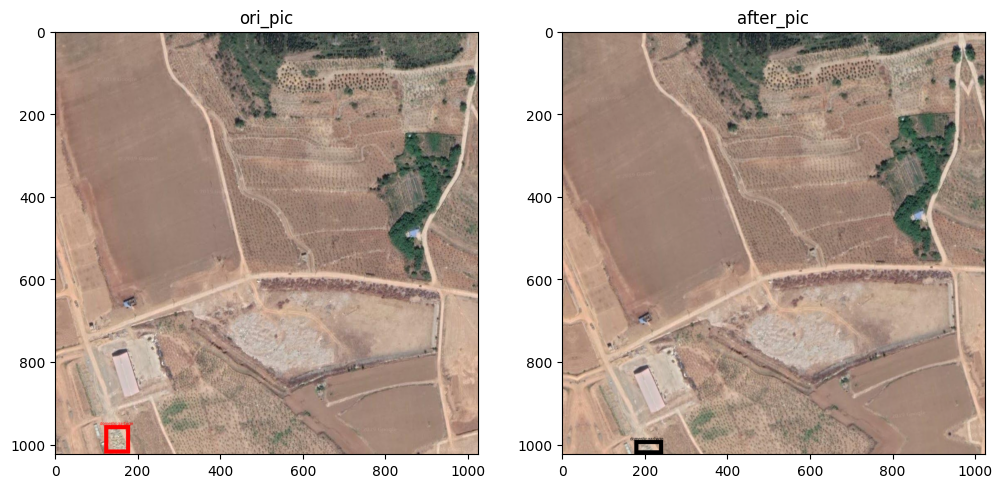

In [144]:
dataset.compare_pic(32)

#### 原图与处理后的图片对比（含有边框）

In [145]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision

In [146]:
# num_classes = 6
# model = fasterrcnn_resnet50_fpn(pretrained=True)
# input_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

In [147]:
model = fasterrcnn_resnet50_fpn(pretrained=False)
checkpoint_path = './fasterrcnn_resnet50_fpn.pth'
model.load_state_dict(torch.load(checkpoint_path))
num_classes = 6
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

c:\Users\learn\.conda\envs\pytorch_comp9444\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\learn\.conda\envs\pytorch_comp9444\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [124]:
for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr=0.0025, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

In [129]:
epochs = 1
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
loss_epochs = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(epochs):
    loss_epoch = []
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        filtered_images = []
        filtered_targets = []
        for image, target in zip(images, targets):
            if target['boxes'].numel() > 0:
                filtered_images.append(image)
                filtered_targets.append({box: label.to(device) for box, label in target.items()})
        
        if len(filtered_targets) == 0:
            continue
        
        optimizer.zero_grad()
        loss = model(filtered_images, filtered_targets)
        losses = sum(loss for loss in loss.values())
        losses.backward()
        optimizer.step()
        loss_epoch.append(losses.item())
        print(losses.item())
    loss_epochs.append(np.mean(loss_epoch))
    
    lr_scheduler.step()
    checkpoint_path = f"model_epoch_{epoch + 1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'lr_scheduler_state_dict' : lr_scheduler.state_dict(),
        'loss' : losses.item(),
    }, checkpoint_path)

转换前： tensor([[714., 278., 783., 394.]]) tensor([5])
转换后： tensor([[241., 630., 310., 746.]]) tensor([5])
转换前： tensor([[350., 636., 421., 704.]]) tensor([1])
转换后： tensor([[410.6091, 267.9396, 507.3970, 365.3811]]) tensor([1])
转换前： tensor([[854., 841., 888., 878.]]) tensor([4])
转换后： tensor([[877.2756, 810.8010, 917.8549, 848.7357]]) tensor([4])
转换前： tensor([[731., 880., 778., 925.],
        [467., 812., 618., 900.]]) tensor([4, 1])
转换后： tensor([[ 462.4716,  940.1472,  525.5648, 1002.4891],
        [ 568.0068,  750.6266,  742.7674,  901.7248]]) tensor([4, 1])
转换前： tensor([[636., 884., 739., 971.]]) tensor([4])
转换后： tensor([[243.2432,  66.5417, 353.8973, 162.7552]]) tensor([4])
转换前： tensor([[362., 477., 412., 532.]]) tensor([4])
转换后： tensor([[375.4469, 549.8947, 447.3761, 623.2791]]) tensor([4])
转换前： tensor([[135., 212., 195., 268.]]) tensor([4])
转换后： tensor([[829., 756., 889., 812.]]) tensor([4])
转换前： tensor([[732., 851., 840., 937.]]) tensor([5])
转换后： tensor([[677.6104,  49.5631, 795.9275

In [148]:
loss_epochs

[0.4492359333141835]

In [398]:
final_model_path = "final_model.pth"
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'lr_scheduler_state_dict':lr_scheduler.state_dict(),
    'loss':losses.item(),
}, final_model_path)

转换前： tensor([[ 897.,  958.,  950., 1022.]]) tensor([4])
转换后： tensor([[854.9228,   0.0000, 912.8777,  36.6016]]) tensor([4])


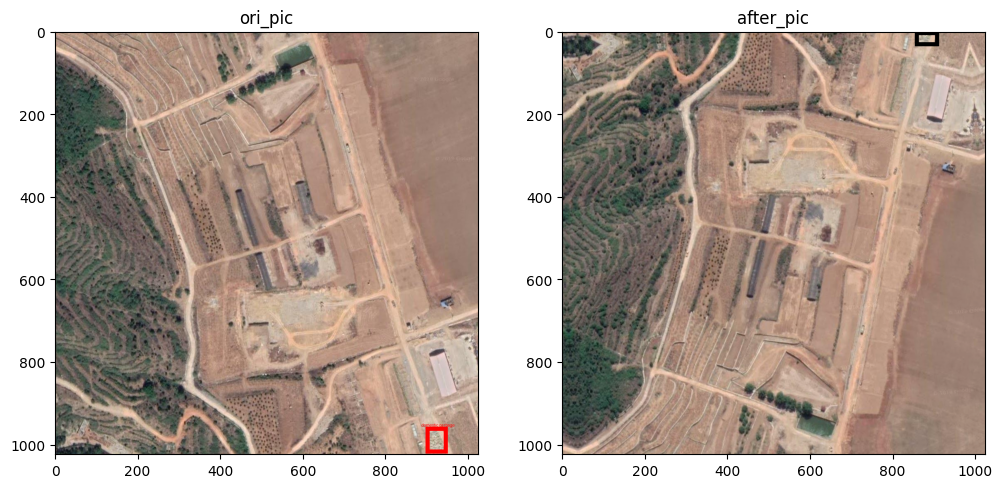

In [153]:
dataset.compare_pic(77)